In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pickle

import re
import emoji
import numpy as np
from nltk.tokenize.casual import EMOTICON_RE

from tqdm import tqdm
#nltk.download('wordnet')
#nltk.download('words')
from nltk.sentiment.util import mark_negation
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

from collections import Counter
from wordcloud import WordCloud
from nltk import FreqDist

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

DATASET_COLUMNS = ['Id', 'Review', 'Sentiment']
senti_labels = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
senti_categories = list(senti_labels.values())
NUM_of_CLASSES = 3

input_folder_path = "./pls/Thesis_Jupyter_Final/input/"
processed_folder_path = "./pls/Thesis_Jupyter_Final/processed"
data_filename = "reviews_data.csv"
cleaned_data_filename = "cleaned_data.csv"
vocab_filename = 'vocab.txt'

Goal of project: 

This notebook includes: (steps)

# Load Data

First, we load and explore the dataset and apply some initial processing such as setting the '*Id*' column as index and removing any empty rows.

In [19]:
def drop_missing(data):
    # Remove any rows with missing values and reset the index
    data.replace('', np.nan, inplace=True)
    data = data.dropna()
    data.reset_index(drop=True, inplace=True)
    return data

In [20]:
data_file_path = os.path.join(input_folder_path, data_filename)
df_raw = pd.read_csv(data_file_path)
df_raw = df_raw

# Set ID as index
df_raw.set_index('Id', inplace=True, drop=True)

# Remove NaN rows, before cleaning text
df_raw = drop_missing(df_raw)

print(df_raw.info())
print(f'\nDataset shape: {df_raw.shape}\n')
df_raw.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Review     107018 non-null  object
 1   Sentiment  107018 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
None

Dataset shape: (107018, 2)



,Review,Sentiment
0,good and interesting,3
1,This class is very helpful...,3
2,like!Prof and TAs are help...,3
3,Easy to follow and include...,3
4,Really nice teacher!I coul...,3
5,Great course - I recommend...,3
6,One of the most useful cou...,3
7,I was disappointed because...,2
8,Super content. I'll defini...,3
9,One of the excellent cours...,3


### Analysing Data (TODO)
We then analyse the dataset by observing the distribution of review per sentiment.

In [21]:
def print_senti_counts(counts):
    # Print the number of reviews per sentiment 
    for senti_value, count in counts.items():
        sentiment_name = senti_labels[senti_value]
        print(f"{senti_value} ({sentiment_name}): {count} reviews")

def plot_senti_counts(counts):
    # Plot counts per sentiment
    colors = ['limegreen', 'dodgerblue', 'red']
    plt.pie(counts, colors=colors, autopct='%1.1f%%',  pctdistance=0.8, textprops={'fontsize': 10, 'color': 'black'}, startangle=90)
    plt.axis('equal')  # pie as a circle
    plt.legend(labels=senti_categories[::-1], loc='lower left')
    plt.title('Distribution of Reviews per Sentiment')
    plt.show()

def count_words(text):
    # Count words per review
    return len(str(text).split(' '))

3 (Positive): 97227 reviews
2 (Neutral): 5071 reviews
1 (Negative): 4720 reviews


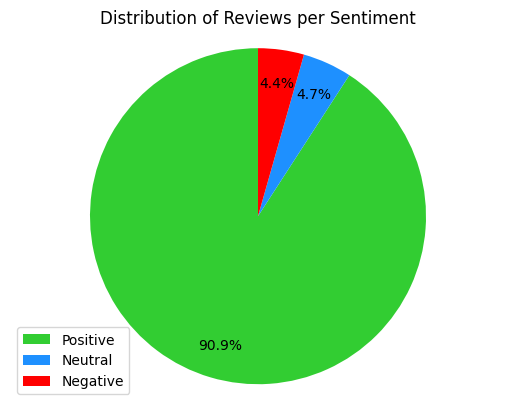

In [22]:
senti_counts = df_raw['Sentiment'].value_counts()
print_senti_counts(senti_counts)
plot_senti_counts(senti_counts)

In [23]:
# Calculate total and average word count without adding a new column to the dataframe
total_word_count = df_raw['Review'].apply(count_words).sum()
avg_review_len = df_raw['Review'].apply(count_words).mean()

print("Total word count: ", total_word_count)
print(f"Average review length: {avg_review_len:.2f}")

Total word count:  2661665
Average review length: 24.87


In [24]:
# Create a copy of the original DataFrame to preserve the original data
df = df_raw.copy()
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_colwidth', 30) 

## Clean Text

Next, we clean the data applying the following techniques (TODO: add info):

In [25]:
# Text Cleaning
#english_words = set(nltk.corpus.words.words())
emojis = [
        #HAPPY
        ":-)",
        ":)",
        ";)",
        ":o)",
        ":]",
        ":3",
        ":c)",
        ":>",
        "=]",
        "8)",
        "=)",
        ":}",
        ":^)",
        ":-D",
        ":D",
        "8-D",
        "8D",
        "x-D",
        "xD",
        "X-D",
        "XD",
        "=-D",
        "=D",
        "=-3",
        "=3",
        ":-))",
        ":'-)",
        ":')",
        ":*",
        ":^*",
        ">:P",
        ":-P",
        ":P",
        "X-P",
        "x-p",
        "xp",
        "XP",
        ":-p",
        ":p",
        "=p",
        ":-b",
        ":b",
        ">:)",
        ">;)",
        ">:-)",
        "<3",
        # SAD
        ":L",
        ":-/",
        ">:/",
        ":S",
        ">:[",
        ":@",
        ":-(",
        ":[",
        ":-||",
        "=L",
        ":<",
        ":-[",
        ":-<",
        "=\\",
        "=/",
        ">:(",
        ":(",
        ">.<",
        ":'-(",
        ":'(",
        ":\\",
        ":-c",
        ":c",
        ":{",
        ">:\\",
        ";(",
    ]

In [26]:
# 1) Lowercase
df['Review'] = df['Review'].str.lower()
df.head()

,Review,Sentiment
0,good and interesting,3
1,this class is very helpful...,3
2,like!prof and tas are help...,3
3,easy to follow and include...,3
4,really nice teacher!i coul...,3


In [27]:
# 2) Replace contractions with their standard full forms
contraction_mapping = {
        "isn't": "is not",
        "aren't": "are not",
        "don't": "do not",
        "doesn't": "does not",
        "wasn't": "was not",
        "weren't": "were not",
        "didn't": "did not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not",
        "won't": "will not",
        "can't": "cannot",
        "couldn't": "could not",
        "shouldn't": "should not",
        "wouldn't": "would not",
        "mightn't": "might not",
        "mustn't": "must not",
        }

for contraction, standard in contraction_mapping.items():
    df['Review'] = df['Review'].str.replace(contraction, standard)

print(df)

                               Review  Sentiment
0                good and interesting          3
1       this class is very helpful...          3
2       like!prof and tas are help...          3
3       easy to follow and include...          3
4       really nice teacher!i coul...          3
...                               ...        ...
107013  trendy topic with talks fr...          3
107014  wonderful! simple and clea...          3
107015  an interesting and fun cou...          3
107016  very broad perspective, up...          3
107017  an informative course on t...          3

[107018 rows x 2 columns]


In [28]:
# 3) Remove punctuation in between words e.g. "course.sometimes", "i'll" and replace with space
pattern = r'(?<=\w)[^\w\s]+(?=\w)'
df['Review'] = df['Review'].str.replace(pattern, ' ')
print(df)

/tmp/ipykernel_936275/1580789109.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Review'] = df['Review'].str.replace(pattern, ' ')


                               Review  Sentiment
0                good and interesting          3
1       this class is very helpful...          3
2       like prof and tas are help...          3
3       easy to follow and include...          3
4       really nice teacher i coul...          3
...                               ...        ...
107013  trendy topic with talks fr...          3
107014  wonderful! simple and clea...          3
107015  an interesting and fun cou...          3
107016  very broad perspective, up...          3
107017  an informative course on t...          3

[107018 rows x 2 columns]


In [29]:
# 4) Tokenize text into individual words (removes all extra spaces \s)
tokenizer = TweetTokenizer()
df['Review'] = df['Review'].apply(tokenizer.tokenize)
df.head()

,Review,Sentiment
0,"[good, and, interesting]",3
1,"[this, class, is, very, he...",3
2,"[like, prof, and, tas, are...",3
3,"[easy, to, follow, and, in...",3
4,"[really, nice, teacher, i,...",3


In [30]:
# 5) Remove punctuation first in between words (typo), and then all punctuation and numerals except for tokenized emojis
pattern = r"[^\w\s" + "".join(re.escape(e) for e in emojis + list(emoji.EMOJI_DATA.keys())) + "]|[\d]+" # match non-emoji special characters
df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if not re.match(pattern, token)])
print(df)

                               Review  Sentiment
0            [good, and, interesting]          3
1       [this, class, is, very, he...          3
2       [like, prof, and, tas, are...          3
3       [easy, to, follow, and, in...          3
4       [really, nice, teacher, i,...          3
...                               ...        ...
107013  [trendy, topic, with, talk...          3
107014  [wonderful, simple, and, c...          3
107015  [an, interesting, and, fun...          3
107016  [very, broad, perspective,...          3
107017  [an, informative, course, ...          3

[107018 rows x 2 columns]


In [31]:
# 6) Remove single characters
df['Review'] = df['Review'].apply(lambda tokens: [word for word in tokens if len(word) > 1])
print(df)

                               Review  Sentiment
0            [good, and, interesting]          3
1       [this, class, is, very, he...          3
2       [like, prof, and, tas, are...          3
3       [easy, to, follow, and, in...          3
4       [really, nice, teacher, co...          3
...                               ...        ...
107013  [trendy, topic, with, talk...          3
107014  [wonderful, simple, and, c...          3
107015  [an, interesting, and, fun...          3
107016  [very, broad, perspective,...          3
107017  [an, informative, course, ...          3

[107018 rows x 2 columns]


In [32]:
# 7) Correct Spelling
# Note: also removes '...' that was not removed before
def correct_spelling(tokens):
    corrected_tokens = []
    for token in tokens:
        if token in emojis or token in emoji.EMOJI_DATA.keys():
            corrected_tokens.append(token)  # If token is an emoji, add it to the corrected tokens
        else:
            corrected_token = spell_checker.correction(token)
            if corrected_token is not None:
                corrected_tokens.append(corrected_token)
                
    return corrected_tokens

In [ ]:
spell_checker = SpellChecker()
#df['Review'] = df['Review'].apply(lambda x: list(tqdm(correct_spelling(x), leave=False)))
# Apply correct_spelling function using tqdm
for i, row in tqdm(df.iterrows(), total=len(df)):
    df.at[i, 'Review'] = correct_spelling(row['Review'])
    print("Processed row:", i)
    
print(df)

In [ ]:
# TODO: note to self (to be added to word-doc): If you check token by token, it also removes english words

In [ ]:
# 8) Perform negation tagging
df['Review'] = df['Review'].apply(mark_negation)
print(df)

In [ ]:
# 9) Remove stopwords --> also removes words like 'not'
stop_words = set(stopwords.words('english'))
df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token.split('_')[0] not in stop_words])
print(df)

In [ ]:
# 10) Lemmatize words using WordNetLemmatizer (also lemmatizes words removing _NEG)
def lemmatize_token(token):
    lemmatizer = WordNetLemmatizer()
    if "_NEG" in token:
        word, tag = token.split("_NEG")
        return lemmatizer.lemmatize(word) + "_NEG"
    else:
        return lemmatizer.lemmatize(token)

In [ ]:
df['Review'] = df['Review'].apply(lambda tokens: [lemmatize_token(token) for token in tokens])
print(df)

In [ ]:
# Convert preprocessed tokens back to string
df['Review'] = df['Review'].apply(' '.join)
df.head()

## Data Cleaning after Text Cleaning

In [ ]:
print(f'Shape before: {df_raw.shape}')
print(f'Shape after preprocessing, before removing empty rows: {df.shape}')

# Remove NaN rows, after cleaning text
df = drop_missing(df) 
print(f'Shape after preprocessing, after removing empty rows: {df.shape}\n')

In [ ]:
data_file_path = os.path.join(input_folder_path, cleaned_data_filename)
df.to_csv(data_file_path, sep=',', index_label='Id')

# EDA Functions

In [ ]:
def make_wordcloud(word_counts):
    wordcloud = WordCloud().generate_from_frequencies(word_counts)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [ ]:
def plot_word_freq_most_common(dataset, num_most_common=60):
    all_words = [word for review in dataset for word in review.split()]

    fdist = FreqDist(all_words)
    plt.figure(figsize=(10, 5))
    fdist.plot(num_most_common, title=f'Frequency Distribution of Most Common {num_most_common} Tokens')
    plt.show()

In [ ]:
def plot_word_freq_cdf(word_counts, max_count):
    frequencies = list(word_counts.values())
    sorted_counts = np.sort(frequencies) # ascending

    # Calculate the cumulative sum of the sorted frequencies & normalize
    cumu_counts = np.cumsum(sorted_counts)
    cdf = cumu_counts / cumu_counts[-1]

    # Plot the CDF
    plt.plot(sorted_counts, cdf)
    plt.xlabel('Word Frequency')
    plt.ylabel('CDF')
    plt.title('CDF of Word Frequencies')
    x_ticks = np.arange(0, max_count, 500)
    plt.xticks(x_ticks)
    plt.grid(True)
    plt.show()

In [ ]:
def plot_word_freq_hist(word_counts):
    # Set up a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot word frequency distribution with linear scale
    ax1.hist(word_counts.values(), bins=range(1, 50), alpha=0.5)
    ax1.set_title('Word Frequency Distribution (Linear Scale)')
    ax1.set_xlabel('Word Frequency')
    ax1.set_ylabel('Number of Words')

    # Plot word frequency distribution with logarithmic scale
    ax2.hist(word_counts.values(), bins=range(1, 500, 10), alpha=0.5)
    ax2.set_yscale('log')
    ax2.set_title('Word Frequency Distribution (Logarithmic Scale)')
    ax2.set_xlabel('Word Frequency')
    ax2.set_ylabel('Number of Words')

In [ ]:
def calculate_word_statistics(word_counts):
    freqs = np.array(list(word_counts.values()))

    print("Mean frequency: ", np.mean(freqs))
    print("Median frequency: ", np.median(freqs))
    print("Max frequency: ", max(freqs))
    print("Min frequency: ", min(freqs))
    print("Standard deviation: ", np.std(freqs))
    print("1st quartile: ", np.percentile(freqs, 25))
    print("3rd quartile: ", np.percentile(freqs, 75))

# Preprocess Data

First we load cleaned data.

In [ ]:
data_file_path = os.path.join(input_folder_path, cleaned_data_filename)
df = pd.read_csv(data_file_path)

### Split train and test

In [ ]:
# Split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(df['Review'], df['Sentiment'], test_size=0.2, random_state=42)
# Split the training dataset further into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))
print(f"x_train: {x_train.head()}")

### Create & Analyse Vocabulary

In [ ]:
# Count words to create vocabulary
word_freqs = Counter()
for review in x_train:
    word_freqs.update(review.split())

word_freqs_len = len(word_freqs)

print(f"50 Most common words: {word_freqs.most_common(50)}")
print(f"Unfiltered vocab size: {word_freqs_len}")

In [ ]:
calculate_word_statistics(word_freqs)

In [ ]:
#make_wordcloud(word_freqs)
plot_word_freq_most_common(x_train, 60) # Zipf's law plot, large number of words have very low frequencies
plot_word_freq_cdf(word_freqs, max(word_freqs.values()))
plot_word_freq_hist(word_freqs)

Around 90% of the words in the vocabulary occur 700 times or less.

In [ ]:
# PROCESSING-CONSTANTS
MIN_WORD_FREQ = 10
MAX_WORD_FREQ = 700

In [ ]:
# Filter vocabulary by removing words with frequency less than a set minimum frequency
vocab = [word for word, count in word_freqs.items() if (count >= MIN_WORD_FREQ) and (count <= MAX_WORD_FREQ)]
vocab_size = len(vocab)
print("Vocabulary size of {} reduced to {}.\n".format(word_freqs_len, vocab_size))
print("Vocabulary (first 50 tokens):\n{}".format(vocab[:50]))

In [ ]:
filtered_word_freq = {word: word_freqs[word] for word in vocab}
calculate_word_statistics(filtered_word_freq)

In [ ]:
# Create the folder if it doesn't exist
if not os.path.exists(processed_folder_path):
    os.makedirs(processed_folder_path)

file_path = os.path.join(processed_folder_path, vocab_filename)
with open(file_path, 'w') as file:
    file.write('\n'.join(vocab))

### Filter data with vocabulary

In [ ]:
def freq_filter_dataset(docs, filename, vocab):
    filtered_dataset = []
    for doc in docs:
        filtered_text = ' '.join([word for word in doc.split() if word in vocab])
        filtered_dataset.append(filtered_text)

    # Save filtered dataset to a txt file
    filtered_filename = f'filtered_{str(filename)}.txt'
    file_path = os.path.join(processed_folder_path, filtered_filename)
    with open(file_path, 'w') as file:
        file.write('\n'.join(filtered_dataset))

    # Convert the processed documents back to pandas.Series
    filtered_dataset = pd.Series(filtered_dataset, index=docs.index)


    '''
    # Convert empty rows to '<empty>'
    placeholder = "<empty>"
    filtered_dataset.replace('', placeholder, inplace=True)
    
    # Count the number of rows with '<empty>' #TODO: remove empty rows
    num_empty_rows = filtered_dataset.str.count('<empty>').sum()
    print(f'Number of rows with <empty> for {filename}: {num_empty_rows}')

    # TODO: instead of saving, print?
    # Save filled dataset to a txt file
    filled_filename = f'filled_{str(filename)}.txt'
    file_path = os.path.join(processed_folder_path, filled_filename)
    with open(file_path, 'w') as file:
        file.write('\n'.join(filtered_dataset))
    '''
    
    return filtered_dataset

In [ ]:
# Filter dataset based on vocabulary
x_train = freq_filter_dataset(x_train, "x_train", vocab)
x_val = freq_filter_dataset(x_val, "x_val", vocab)
x_test = freq_filter_dataset(x_test, "x_test", vocab)

print("\nData Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))
print(f"x_train - updated: {x_train.head()}")

In [ ]:
def drop_empty_rows(x, y):
    # Merge X and Y datasets
    merged = pd.concat([x, y], axis=1)

    # Drop empty rows
    merged.replace('', np.nan, inplace=True)
    merged = merged.dropna(subset=['text'], inplace=True) # TODO: subset?

    # Re-assign X and Y datasets
    x_filtered = x['Review']
    y_filtered = y['Sentiment']

    return x_filtered, y_filtered

In [ ]:
x_train, y_train = drop_empty_rows(x_train, y_train)
x_val, y_val = drop_empty_rows(x_val, y_val)
x_test, y_test = drop_empty_rows(x_test, y_test)
print(x_train.shape, y_train.shape())

In [ ]:
# TODO: remove words less than 3 words from data
# TODO: remove data rows instead of <empty>
# TODO: EDA for raw data
# TODO: save train, val, and test data (edit freq_filter function and add a saving function)

# Balance Data

We remove positive reviews that have 3 words or less...

Dataset length reduced from 107018 to 100825
Dataset shape: (100825, 2)
3 (Positive): 91034 reviews
2 (Neutral): 5071 reviews
1 (Negative): 4720 reviews


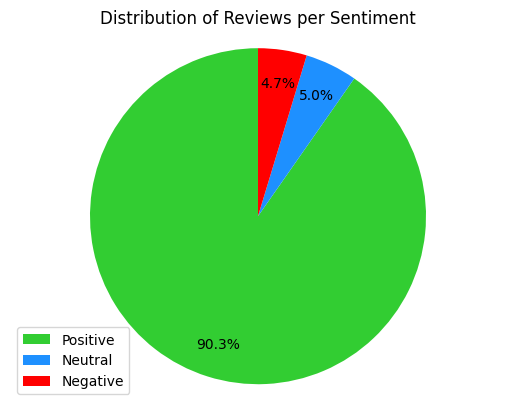

Total word count:  2650294
Average review length: 26.29


In [ ]:
condition = ~((df['Sentiment'] == 3) & (df['Review'].apply(count_words) < 3))
df = df[condition]

print(f"Dataset length reduced from {df_raw.shape[0]} to {df.shape[0]}")

In [ ]:
# The "strategy" parameter can take a dict, callable, or str as input
# You might need to adjust these parameters according to the distribution of your classes
over_strategy = {1: 10000, 2: 10000} # Over-sample minority classes
under_strategy = {3: 50000} # Under-sample majority classes

# Define pipeline
over = RandomOverSampler(sampling_strategy=over_strategy)
under = RandomUnderSampler(sampling_strategy=under_strategy)
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Applying the balancing pipeline to both x and y datasets
x_balanced, y_balanced = pipeline.fit_resample(pd.DataFrame(x_train), y_train)

# Print out the new class distribution
counter = Counter(y_balanced)
print(counter)

x_train = x_balanced.copy()
y_train = y_balanced.copy()

print(x_train, y_train)


In [ ]:
print(f"Dataset shape: {df.shape}")
senti_counts = df['Sentiment'].value_counts()
print_senti_counts(senti_counts)
plot_senti_counts(senti_counts)

# Calculate total and average word count without adding a new column to the dataframe
total_word_count = df['Review'].apply(count_words).sum()
avg_review_len = df['Review'].apply(count_words).mean()

print("Total word count: ", total_word_count)
print(f"Average review length: {avg_review_len:.2f}")

In [ ]:
print(df)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
def save_data(x, y, filename):
    # Save filtered dataset to a csv file

    # Merge X and Y datasets
    merged_df = pd.concat([x, y], axis=1)
    file_path = os.path.join(input_folder_path, filename)
    merged_df.to_csv(file_path, sep=',', index_label='Id')

save_data(x_train, y_train, "train.csv")
save_data(x_val, y_val, "val.csv")
save_data(x_test, y_test, "test.csv")